Basic notebook for applying a simple sklearn prediction method on the kaggle titanic dataset

In [1]:
import os

In [2]:
DATASET_COMP = 'titanic'
DATA_DIR = './data'
DATA_ZIP = 'titanic.zip'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'

VALIDATION_SPLIT = 0.2
TARGET_VAR = 'Survived'

In [3]:
# load and prep datset from kaggle
if not os.listdir(DATA_DIR):
    print('data folder is empty. Downloading data...')
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    api.competition_download_files(DATASET_COMP, DATA_DIR, quiet = False)

if not os.path.exists(os.path.join(DATA_DIR,TRAIN_CSV)) and os.path.exists(os.path.join(DATA_DIR,DATA_ZIP)):
    print('data set downloaded, unzipping...')
    import zipfile
    with zipfile.ZipFile(os.path.join(DATA_DIR, DATA_ZIP), 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)


In [4]:
# load data into pandas dataframe
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_CSV))
test_df = pd.read_csv(os.path.join(DATA_DIR, TEST_CSV))

# create train and validation set from train_df, splitting out target column
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(TARGET_VAR, axis = 1), train_df[TARGET_VAR], test_size = VALIDATION_SPLIT, random_state = 42)

In [5]:
# take a quick look at the tarining data set
print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train.head()


X_train shape:  (712, 11)
X_val shape:  (179, 11)
y_train shape:  (712,)
y_val shape:  (179,)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


In [6]:
# print the number of unique values of each categorical column
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(col, ': ', X_train[col].nunique())

Name :  712
Sex :  2
Ticket :  558
Cabin :  117
Embarked :  3


### Preprocessing Piple
We will use a combination of Pipelines and column transformers to setup the data
1. Tranform "Cabin" feature to a binary "has_cabin" feature
2. Setup a column transformer for numerical values which impute with median and StandardScaler
3. Setup a column transformer for categorical features which ignore unknown(s)
4. Setup a column transformer to drop unwanted columns

In [7]:
from sklearn.pipeline import Pipeline
preprocess_pipeline = Pipeline(steps=[])

1. **Tranform "Cabin" feature to a binary "has_cabin" feature**

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class DummyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols = None):
        """
        Dummy class to minimize code duplication
        from: https://towardsdatascience.com/customizing-sklearn-pipelines-transformermixin-a54341d8d624
        """
        self.cols = cols
        self.dummies = None
        return None
    
    def fit(self, X = None, y = None):
        return self

    def transform(self, X = None, y = None):
        return self
    

In [9]:
class ImputeCabinTransformer(DummyTransformer):
    """Impute Cabin feature to has_cabin feature as binary"""
    def __init__(self, feature_name, new_name):
        self.feature_name = feature_name
        self.new_name = new_name

    def fit(self, X, y=None):
        X_ = X.rename(columns={self.feature_name:self.new_name})
        self.columns = [col for col in X_.columns]
        return self

    def transform(self, X):
        X_ = X.drop(labels = self.feature_name, axis = 1)
        X_[self.new_name] = X[self.feature_name].notna().replace({True: 1, False: 0})

        return X_


In [10]:
CabinImputer = ImputeCabinTransformer(feature_name = 'Cabin', new_name = 'hasCabin')
preprocess_pipeline.steps.append(('CabinImputer', CabinImputer))

In [11]:
display(preprocess_pipeline)

Pipeline(steps=[('CabinImputer',
                 ImputeCabinTransformer(feature_name='Cabin',
                                        new_name='hasCabin'))])

2. **Setup a column transformer for numerical values which impute with median and StandardScaler**

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [13]:
numerical_cols = ['Age','Fare']
numerical_pipeline = Pipeline(steps=[
    ('MedianImuter', SimpleImputer(strategy='mean')),
    ('StandardScaler', StandardScaler())
])

3. **Setup a column transformer for categorical features which ignore unknown(s)**

In [14]:
categorical_cols = ['Pclass','Sex','Embarked']
categorical_vals = [[1,2,3],['male','female'],['C','Q','S']]
categorical_pipeline = Pipeline(steps=[
    ('OHE',OneHotEncoder(handle_unknown='ignore',sparse_output=False,dtype='int16',
                         categories=categorical_vals))
])

In [15]:
drop_cols = ['PassengerId','Name','Ticket']
minMax_cols = ['SibSp','Parch']
ColumnTransform = ColumnTransformer(
    transformers=[
        ('numerical',numerical_pipeline,numerical_cols),
        ('categorical',categorical_pipeline,categorical_cols),
        ('drop','drop',drop_cols),
        ('MinMax',MinMaxScaler(),minMax_cols)
    ], remainder='passthrough'
)

preprocess_pipeline.steps.append(('ColumnTransform',ColumnTransform))

In [16]:
display(preprocess_pipeline.fit(X_train))

Pipeline(steps=[('CabinImputer',
                 ImputeCabinTransformer(feature_name='Cabin',
                                        new_name='hasCabin')),
                ('ColumnTransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('MedianImuter',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2,
                                                                                              3],
                                                                                             ['male',
                                                                                              'female'],
                                                                                             ['C',
                                                                                              'Q',
                                                                                              'S']],
                                                                                 dtype='int16',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('drop', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['SibSp', 'Parch'])]))])

We are going to follow a similar process that is defined in this medium article for evlauting several different pipelines using GridSearchCV

https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3

In [18]:
# Import the logistiic regression, kneighbors, random forest, Decision tree, XGBoost, and svm classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm

from sklearn.model_selection import GridSearchCV

In [24]:
RANDOM_STATE = 42

pipe_lr = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('LR',LogisticRegression(random_state=RANDOM_STATE))
    ])

pipe_dt = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('DT',DecisionTreeClassifier(random_state=RANDOM_STATE))
])

pipe_rf = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('RF',RandomForestClassifier(random_state=RANDOM_STATE))
])

pipe_knn = Pipeline(steps=[
    ('preprocess',preprocess_pipeline),
    ('KNN',KNeighborsClassifier())
])

pipe_svm = Pipeline(steps=[
    ('preprocess',preprocess_pipeline),
    ('SVM',svm.SVC(random_state=RANDOM_STATE))
])

pipe_gb = Pipeline(steps=[
    ('preprocess',preprocess_pipeline),
    ('GB',GradientBoostingClassifier(random_state=RANDOM_STATE))
])

In [46]:
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50, 100, 200]
learning_rates = [0.05, 0.1, 0.25]

lr_param_grid = [{'LR__penalty': ['l1','l2'],
                  'LR__C': param_range_fl,
                  'LR__solver': ['liblinear']}]

dt_param_grid = [{'DT__criterion': ['gini','entropy'],
                  'DT__min_samples_leaf': param_range,
                  'DT__max_depth': param_range,
                  'DT__min_samples_split':param_range[1:]}]

rf_param_grid = [{
    'RF__min_samples_leaf': param_range,
    'RF__max_depth': param_range,
    'RF__min_samples_split': param_range[1:] 
}]

knn_param_grid = [{
    'KNN__n_neighbors': param_range,
    'KNN__weights': ['uniform', 'distance'],
    'KNN__metric': ['euclidean', 'manhattan']
}]

svm_param_grid = [{
    'SVM__kernel': ['linear','rbf'],
    'SVM__C': param_range
}]

gb_param_grid = [{
    'GB__learning_rate': learning_rates,
    'GB__max_depth': param_range,
    'GB__subsample': param_range_fl,
    'GB__n_estimators': n_estimators
}]

In [47]:
lr_grid_search = GridSearchCV(pipe_lr, lr_param_grid, scoring='accuracy',cv = 3, verbose=9)

dt_grid_search = GridSearchCV(pipe_dt, dt_param_grid, scoring='accuracy',cv = 3, verbose=9)

rf_grid_search = GridSearchCV(pipe_rf, rf_param_grid, scoring='accuracy',cv = 3, verbose=9)

knn_grid_search = GridSearchCV(pipe_knn, knn_param_grid, scoring='accuracy',cv = 3, verbose=9)

svm_grid_search = GridSearchCV(pipe_svm, svm_param_grid, scoring='accuracy',cv = 3, verbose=9)

gb_grid_search = GridSearchCV(pipe_gb, gb_param_grid, scoring='accuracy',cv = 3, verbose=9)


In [48]:
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search,
 svm_grid_search, gb_grid_search]

for pipe in grids:
    pipe.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END LR__C=1.0, LR__penalty=l1, LR__solver=liblinear;, score=0.798 total time=   0.0s
[CV 2/3] END LR__C=1.0, LR__penalty=l1, LR__solver=liblinear;, score=0.819 total time=   0.0s
[CV 3/3] END LR__C=1.0, LR__penalty=l1, LR__solver=liblinear;, score=0.806 total time=   0.0s
[CV 1/3] END LR__C=1.0, LR__penalty=l2, LR__solver=liblinear;, score=0.803 total time=   0.0s
[CV 2/3] END LR__C=1.0, LR__penalty=l2, LR__solver=liblinear;, score=0.823 total time=   0.0s
[CV 3/3] END LR__C=1.0, LR__penalty=l2, LR__solver=liblinear;, score=0.806 total time=   0.0s
[CV 1/3] END LR__C=0.5, LR__penalty=l1, LR__solver=liblinear;, score=0.794 total time=   0.0s
[CV 2/3] END LR__C=0.5, LR__penalty=l1, LR__solver=liblinear;, score=0.802 total time=   0.0s
[CV 3/3] END LR__C=0.5, LR__penalty=l1, LR__solver=liblinear;, score=0.810 total time=   0.0s
[CV 1/3] END LR__C=0.5, LR__penalty=l2, LR__solver=liblinear;, score=0.798 total time=   0.0s


In [49]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'KNN', 
             4: 'Support Vector Machines', 5: 'XGBoost'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_val,y_val)))
    print('{} Best Params: {}'.format(grid_dict[i],          model.best_params_))

Logistic Regression Test Accuracy: 0.7988826815642458
Logistic Regression Best Params: {'LR__C': 0.5, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 0.7988826815642458
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 3, 'DT__min_samples_leaf': 5, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 0.8268156424581006
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5}
KNN Test Accuracy: 0.8044692737430168
KNN Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 0.8044692737430168
Support Vector Machines Best Params: {'SVM__C': 1, 'SVM__kernel': 'rbf'}
XGBoost Test Accuracy: 0.7988826815642458
XGBoost Best Params: {'GB__learning_rate': 0.05, 'GB__max_depth': 2, 'GB__n_estimators': 50, 'GB__subsample': 1.0}


In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

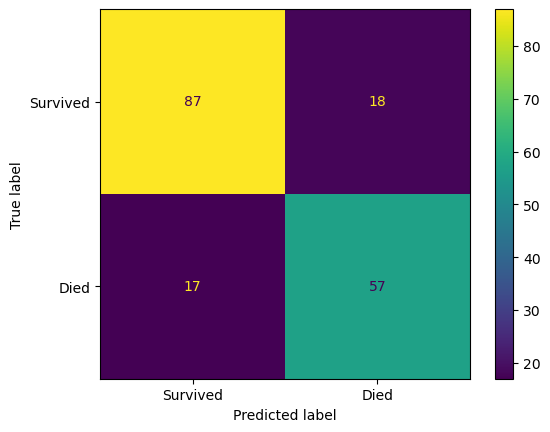

In [51]:
ConfusionMatrixDisplay.from_estimator(knn_grid_search,X_val,y_val,display_labels=['Survived','Died'])

In [55]:
y_val_pred = knn_grid_search.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       105
           1       0.76      0.77      0.77        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



In [57]:
# Prepare submission
submission_preds = knn_grid_search.predict(test_df)
df = pd.DataFrame({"PassengerId": test_df["PassengerId"].values,
                   "Survived": submission_preds,
                  })

df.to_csv("submission.csv", index=False)